In [1]:
import numpy as np
import pandas as pd
import cv2
import gc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
window_size = 50
randomisations = 100

In [3]:
post0_x = 2.0 * np.cos(np.pi / 9)
post0_y = 2.0 * -np.sin(np.pi / 9)

post1_x = 2.0 * np.cos(np.pi / 9)
post1_y = 2.0 * np.sin(np.pi / 9)

In [4]:
df = pd.read_csv("two-choice.csv")

xs = df['rotated_x'].values
ys = df['rotated_y'].values
ts = df['t2'].values
    
df.head()

,Unnamed: 0,rotated_x,rotated_y,t,event,t2
0,0,-0.030048,0.047921,0.000000,0,0
1,1,-0.039665,0.052580,0.776775,0,0
2,2,-0.049949,0.050922,1.767786,0,1
3,3,-0.059154,0.045630,2.086350,0,2
4,4,-0.066259,0.037044,2.451488,0,3


In [5]:
nbins = 500
peak_threshold = 0.9


def density_map(x, y, stats=True):
    val = 201

    blur = (11, 11) if stats == True else (val, val)
    r = [[0, post0_x], [post0_y, post1_y]]

    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)
    tmp_img = np.rot90(cv2.GaussianBlur(h, blur, 0))

    tmp_img /= np.max(tmp_img)

    return tmp_img

In [6]:
def fitfunc(x, p, q, r):
    return r * (np.abs((x - p)) ** q)


def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  # This is added back by InteractiveShellApp.init_path()


0
0
10


/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


20
30
40
50
60
70
70
80
90


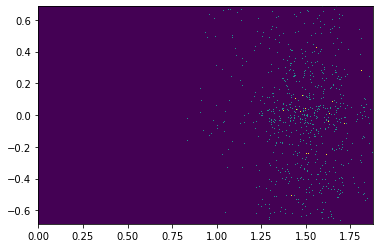

In [7]:
positive_bif = []

while True:
    x_fit = []
    y_fit = []

    bif_pt = 1
    params1 = [1.2, 1, 1]

    x_sub = np.concatenate((xs, xs))
    y_sub = np.concatenate((ys, -ys))
    np.random.shuffle(y_sub)
    t_sub = np.concatenate((ts, ts))

    tmin = 0
    tmax = 250
    for idx, t in enumerate(range(tmin, tmax-window_size, 12)):
        window_min = t
        window_max = t + window_size

        x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
        y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
        tmp_img2 = density_map(x, y, stats=True)

        if idx == 0:
            tmp_img = tmp_img2
        else:
            tmp_img = np.fmax(tmp_img2, tmp_img)

    x_fit = np.where(tmp_img > peak_threshold)[1] * post0_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)
    y_fit = y_fit[x_fit > bif_pt]
    x_fit = x_fit[x_fit > bif_pt]

    try:
        for i in range(0, 10):
            fit_params, pcov = curve_fit(
                fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
            )
            params1 = fit_params

        if (
            (params1[0] > 0)
            & (params1[0] < post0_x)
            & (params1[1] > 0.1)
            & (params1[1] > 2)
            & (params1[2] > 0.2)
        ):
            positive_bif.append(1)
            print(params1)
        else:
            positive_bif.append(0)
    except RuntimeError:
        pass

    if len(positive_bif) >= randomisations:
        break

    if len(positive_bif) % 10 == 0:
        print(len(positive_bif))
        
    del x_sub
    del y_sub
    del t_sub
    del tmp_img
    del tmp_img2
    del x_fit
    del y_fit
    gc.collect()

In [8]:
np.sum(positive_bif) / len(positive_bif), len(positive_bif)

(0.0, 100)